# Computational Intelligence (CI-MAI)
# EAs exercise

Q1 2022-2023, 27-12-2022

---

#### Done by Armando Rodriguez and Hasnain Shafqat

#### Tutor: Lluís Belanche

## Import the necessary packages

In [ ]:
# Basic packages
import time
import math
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
from pandas.core.reshape.reshape import get_dummies

In [ ]:
# EAs packages
!pip install pygad
import pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 2.9 MB/s 


In [ ]:
# Tensorflow packages (for creating the NN)
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model

In [ ]:
# Sklearn packages (for data generation, preprocessing and splitting and some metrics) 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression, make_classification

## Fixed random state

We will be fixing a seed variable (or random state variable), which will allow us to be in control of the randomness of the generated problem and other fluctuation sections in order to be able to replicate the results.

In [ ]:
randomState = 42

## Problem characteristics

* **Classification problem:** We will use a classification problem, specifically, a binary classification problem and the $accuracy$ as the classification score function. The accuracy is basically the number of corrected cases divided by the total number of samples, hence, the accuracy is fitted in the range [0,1]. 0 being the case when none of the samples are well classified and 1, or 100%, being the case when all of them are.
* **Architecture:** We are going to use a Keras Multi-Layer Perceptron network with only a dense (fully connected) layer and a variable number of hidden neurons, which will be found by the genetic algorithm (see next section).
  * We will fix the maximum number of hidden neurons, avoiding the use of any regularization parameter.

* **Synthetic data:** With only **one** generated problem, we will control the following parameters:
  * The sample size of the datasets used for training, validation, and testing. The training size will be set to 70% (or a variable number in one of the sections), while the validation and testing sets will be fixed at 10% and 20%, respectively.
  * The amount of noise added to the output as a result of the fraction of samples whose class is assigned randomly. Larger values introduce noise into the labels and make the classification task harder.
  * The problem hardness that we decided to use the separation of the classes. For this last one, larger values spread out the clusters/classes and make the classification task easier. Hence, smaller values, make the classification task harder. So, what we did was map the hardness value from 0 to 10 into a class separation value of $[2,1,...,0.001]$, being hardness $0$ equal to a class separation of $2$ the easiest problem and hardness $10$ equal to a class separation of $0.001$ the hardest problem.

## Evolution parameters

For the genetic evolutionary parameters, we will use the weights of the hidden layer and the number of neurons in the hidden layer.

* **Weigths:** If we consider $I$ the number of inputs, $T$ the number of targets, and $H$ the number of hidden neurons in the single layer, we will have a total of $I*H$ weights connecting the input and the hidden neurons and $H*T$ weights connecting the hidden neurons and the target ones. Like that, we will have to set a total of $H*(I+T)$ weigths which will initially range from 0 to 1 (an assumption to be made as long as the data will be normalized). We will maintain the bias at 0 in all the neurons.

* **Bias:** Also, for each one of the neurons, we will also study the evolution of their bias, which is the constant value added to the output of the neuron before the activation function.

* **Number of neurons:** For the number of neurons we have decided to set a high value of $2^7=128$ neurons as we think that it is enough for the net to overfit.

An easy example of a representation of an individual in our system can be seen in the following image:

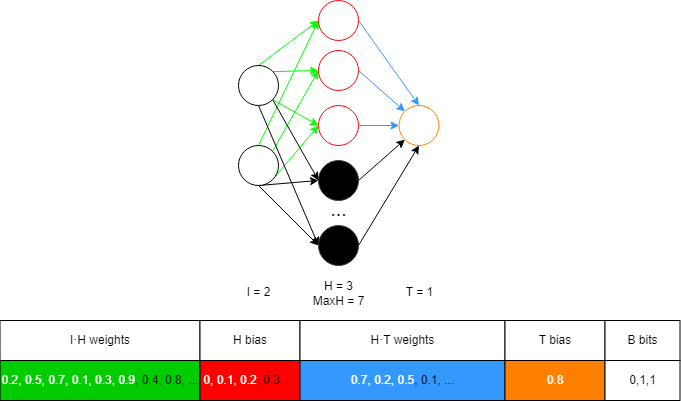

We have a total of 3 bits to represent the maximum number of neurons (7) in our network. We can see that using these last three bits, we are representing a NN of only three hidden neurons (shown in red). In this example, the number of inputs is 2, hence having a total of 14 weights connecting the input layer with the hidden one. Notice how only 3 of these neurons are being used (active) and only 6 weights are being used. In a similar way, the number of biases used is the number of active neurons in the system, while all the others are being ignored.

For the second part of the network, we have similar behavior, with some of the weights not being used for the same reasons explained before. As we will fix the number of inputs to 10 (I), the number of targets to 2 (T) (binary classification), and the number of bits to 7 (maximum of $2^7=128$) we will obtain a final genoma size of $I*H + H + H*T + T + B = 10*128 + 128 + 128*2 + 2 + 7 = 1.673$.

In [ ]:
bitsNumNeurons = 7
maxNumNeurons = 2**bitsNumNeurons

We will also now explain the fitness function used for our genetic algorithms and evolutionary strategy. This fitness function basically creates the neural network using the idea presented in the previous image. We extract the number of active neurons with the last B bits, and then we create the network with the specified input, hidden neurons, and target sizes. The weights and bias for both layers (hidden and output) are then set. Lastly, we compute the accuracy of the model with the training set and use this accuracy score ([0,1]) as the fitness value for the evolutionary algorithm. 

In [ ]:
def _bits2Num(bits):
  res = ''.join(str(x) for x in bits)
  return int(res, 2)

def solToNet(solution, verbose=False):
    bits = solution[-bitsNumNeurons:]
    numNeurons = _bits2Num(np.clip([round(bit) for bit in bits],0,1))
    numNeurons = max(numNeurons, 1)

    model = Sequential()
    model.add(Dense(numNeurons, input_dim=featureSize, activation='relu'))
    model.add(Dense(targetSize, activation='softmax'))
    
    firstWeights = solution[:featureSize*numNeurons].reshape(featureSize,numNeurons)
    firstBias = solution[featureSize*maxNumNeurons:featureSize*maxNumNeurons + numNeurons]
    model.layers[0].set_weights([firstWeights, firstBias])
    
    iniSecondWeights = featureSize*maxNumNeurons + maxNumNeurons
    secondWeights = solution[iniSecondWeights: iniSecondWeights + numNeurons*targetSize].reshape(numNeurons,targetSize)
    iniSecondBias = iniSecondWeights + maxNumNeurons*targetSize
    secondBias = solution[iniSecondBias:iniSecondBias + targetSize]
    model.layers[1].set_weights([secondWeights, secondBias])

    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())

    if verbose:
        print("Num neurons =",numNeurons)
        print("Features size =",featureSize)
        print("Target size =",targetSize)

    return model, numNeurons

def fitness_func(solution, solution_idx):
  model, _ = solToNet(solution)

  y_pred = model.predict(X_train, verbose=0)
  train_accuracy = accuracy_score(np.argmax(y_pred,axis=1), y_train)

  fitness = train_accuracy
  return fitness

## Generate the data

For the data generation, we will use the ``make_classification`` function [[Reference](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)] from Sklearn, which is capable of generating a random classification problem and modifying different parameters from it. As the specification says: "This initially creates clusters of points normally distributed (std=1) about the vertices of a fixed-dimensional hypercube [...] and assigns an equal number of clusters to each class." We will be able to modify the sample size, the noise, and the hardness as mentioned in the syntethic data of the problem characteristics section.

The initial parameters of the data will be the following ones: 

**Fixed variables**

In [ ]:
sampleSize   = 10_000  # 10^5 samples
featureSize  = 10     # Number of features
targetSize   = 2      # Number of classes

**Modificable variables**

In [ ]:
noise    = 0  # Zero noise [0,1] 
hardness = 1  # Hardness is class separation [0,10]

def getClassSeparation(hardness):
  if hardness == 0:
    return 2
  elif hardness == 1:
    return 1
  elif hardness >= 2 and hardness <= 10:
    divided_space = np.linspace(0.001, 1, 10)
    return divided_space[-hardness]

classSeparation = getClassSeparation(hardness)

**Variables summary**

In [ ]:
print("Sample size =",sampleSize)
print("Feature size =",featureSize)
print("Target size =",targetSize)
print("Noise =",noise)
print(f"Hardness = {hardness}, which imply a class separability = {classSeparation}")

Sample size = 10000
Feature size = 10
Target size = 2
Noise = 0
Hardness = 1, which imply a class separability = 1


### Generate the classification problem with the desired parameters

In [ ]:
X, y = make_classification(n_samples=sampleSize, n_features=featureSize, n_informative=featureSize, n_redundant=0,
                           n_classes=targetSize, flip_y=noise, class_sep=classSeparation, hypercube=False, shift=None, shuffle=False, random_state=randomState)
X = MinMaxScaler().fit_transform(X)

Split the data like 20% for Test, 10% for Validation and the rest (70%) for training purposes.

In [ ]:
X_aux, X_test, y_aux, y_test = train_test_split(X, y, test_size=0.20, random_state=randomState, stratify=y) # Get 20% for test set
# Get 10% for validation set (using 0.125 as the extraction is being made from the 80% resting dataset and 0.125*0.8=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_aux, y_aux, test_size=0.125, random_state=randomState, stratify=y_aux)
print("Total sample size =",len(y))
print("Train size =",len(y_train))
print("Validation size =",len(y_val))
print("Test size =",len(y_test))

Total sample size = 10000
Train size = 7000
Validation size = 1000
Test size = 2000


## Experimentation setup

It is important to mention that we are going to use five different random seeds in order to obtain the results for five different initializations for the experiments performed. Also, it is important to note that these seeds will affect the initialization of the derivative models but will not be used directly in the evolutionary algorithms where we will do 5 different runs (as long as they already involve randomness in the evolutionary process). Then we will get the average of all of them to get a robust result in order to be able to compare the models correctly. As a final note, mention that we will use the same five seeds (or runs) for all the different experiments performed.

## Baseline derivative model (with maximum number of layers)

We test which are the capabilities of a baseline derivative model using the whole number of neurons in the hidden layer and just 50 epochs.

In [ ]:
# Auxiliar function to get scores in the training, validation and test datasets
def getScores(model):
  # Train score
  y_pred_train = model.predict(X_train, verbose=0)
  train_score = accuracy_score(np.argmax(y_pred_train,axis=1), y_train)
  # Validation score
  y_pred_val = model.predict(X_val, verbose=0)
  val_score = accuracy_score(np.argmax(y_pred_val,axis=1), y_val)
  # Test score
  y_pred_test = model.predict(X_test, verbose=0)
  test_score = accuracy_score(np.argmax(y_pred_test,axis=1), y_test)

  return train_score, val_score, test_score

In [ ]:
tf.random.set_seed(randomState)
random.seed(randomState)

model = Sequential()
model.add(Dense(maxNumNeurons, input_dim=featureSize, activation='relu'))
model.add(Dense(targetSize, activation='softmax'))
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())
y_train_one_hot = get_dummies(y_train)
model.fit(X_train,y_train_one_hot,epochs=50,verbose=0)

train_accuracy, val_accuracy, test_accuracy = getScores(model)

print(f"Train accuracy      : {round(train_accuracy*100, 2)}%")
print(f"Validation accuracy : {round(val_accuracy*100, 2)}%")
print(f"Test accuracy       : {round(test_accuracy*100, 2)}%")

Train accuracy      : 89.26%
Validation accuracy : 89.0%
Test accuracy       : 88.7%


We can see that the results are quite good, and they are much better compared to the following baseline evolutionary algorithms.

## Baseline genetic model

We set the number of generations to 100 to let the genetic algorithm learn, as we have seen that it is enough for the task and increasing the value drastically increases the execution time. We set num_parents_mating to 5 as it is a balanced value to obtain new individuals. The sol_per_pop parameter follows a similar trend as the num_generations parameter, as long as having a balanced value is primordial for controlling the execution time and the quality of the solution. The num_genes is explained in the previous sections. 

Moreover, the keep_elitism parameter ensures that only the two best individuals will make it through the next generation. Increasing a lot of this value didn't allow the evolution of the rest of the population in order to explore better solutions. The ranges are defined to be low ([0,1] in the initial state) as long as we have seen that, as long as the data is being normalized, the weights don't need to be really high to obtain good results.

Finally, we have two of the most important parameters, the mutation percentage (which indicates the percentage of individuals that will mutate) and the crossover probability (which indicates the probability of "merging" the individuals).

We will be using the PyGAD library which has an already defined genetic algortihm function called ``pygad.GA``.

In [ ]:
num_generations = 100
num_parents_mating = 5
sol_per_pop = 25
num_genes = featureSize*maxNumNeurons + maxNumNeurons + maxNumNeurons*targetSize + targetSize + bitsNumNeurons
keep_elitism = 2
init_range_low = 0
init_range_high = 1
mutation_percent_genes = 5
crossover_probability = 0.8

In [ ]:
%%time
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating, 
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       gene_type=float,
                       keep_elitism=keep_elitism,
                       crossover_probability=crossover_probability,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       mutation_percent_genes=mutation_percent_genes)
ga_instance.run()

Wall time: 7min 41s


Parameters of the best solution : [ 0.67071953 -0.56093283  0.31127432 ... -0.72953858  1.10098167
  0.90028645]
Fitness value of the best solution = 0.6472857142857142
Index of the best solution : 0


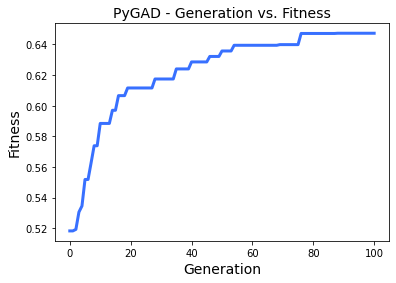

Num neurons = 115
Features size = 10
Target size = 2
Train accuracy      : 64.73%
Validation accuracy : 63.8%
Test accuracy       : 64.2%


In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))
p = ga_instance.plot_fitness()
plt.show()
model, _ = solToNet(solution, verbose=True)
train_accuracy, val_accuracy, test_accuracy = getScores(model)

print(f"Train accuracy      : {round(train_accuracy*100, 2)}%")
print(f"Validation accuracy : {round(val_accuracy*100, 2)}%")
print(f"Test accuracy       : {round(test_accuracy*100, 2)}%")

We can appreciate that in the first 50 generations, the improvement is more noticeable than compared with the last 50 generations. We can see that after a certain point, finding better individuals is more difficult. We can get the same result as the derivative model; however, the increase in the number of generations should be equally proportional.

## Baseline evolutional strategy model

In the evolutional algorithms we will set the same setup but decreasing the crossover probability to 0 and increasing, quite a lot, the mutation percentage. This kind of algorithms or strategies work only with mutation and this idea is the one that we are trying to set over here. 

So, we decided to use a genetic model with only mutation as the evolutional strategy.

In [ ]:
num_generations = 100
num_parents_mating = 5
sol_per_pop = 25
num_genes = featureSize*maxNumNeurons + maxNumNeurons + maxNumNeurons*targetSize + targetSize + bitsNumNeurons
keep_elitism = 2
init_range_low = 0
init_range_high = 1
mutation_percent_genes = 80
crossover_probability = 0

In [ ]:
%%time
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       gene_type=float,
                       keep_elitism=keep_elitism,
                       crossover_probability=crossover_probability,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       mutation_percent_genes=mutation_percent_genes)
ga_instance.run()

Wall time: 13min 24s


Parameters of the best solution : [ 3.83000251 -1.18838884  2.68507631 ...  3.560047    3.79019552
 -4.05954897]
Fitness value of the best solution = 0.6565714285714286


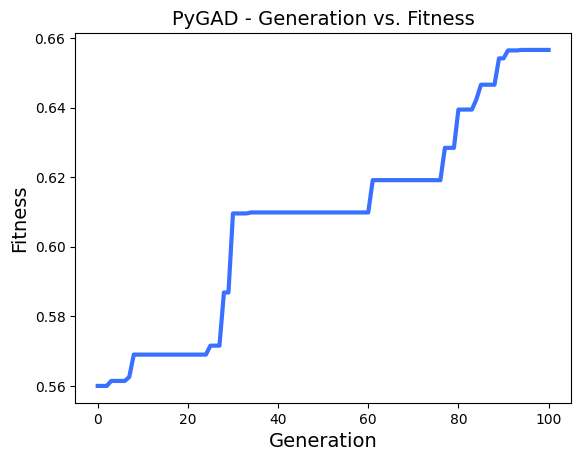

Num neurons = 78
Features size = 10
Target size = 2
Train accuracy      : 65.66%
Validation accuracy : 64.2%
Test accuracy       : 64.35%


In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
p = ga_instance.plot_fitness()
plt.show()
model, _ = solToNet(solution, verbose=True)
train_accuracy, val_accuracy, test_accuracy = getScores(model)

print(f"Train accuracy      : {round(train_accuracy*100, 2)}%")
print(f"Validation accuracy : {round(val_accuracy*100, 2)}%")
print(f"Test accuracy       : {round(test_accuracy*100, 2)}%")

In comparison to the genetic algorithms, we can see that the individuals improve over all the generations. However, we have some generations between the generations of 30 and 60 where we don't find better individuals. Moreover, the same applies to the genetic algorithms: if we increase the number of generations, we can get the same results as the derivative models.

## Search of the best crossover

In this section we will look for the best crossover in the genetic algorithms for this simplest defined problem, i.e., no noise and small hardness.

In [ ]:
num_generations = 50
num_parents_mating = 5
sol_per_pop = 25
num_genes = featureSize*maxNumNeurons + maxNumNeurons + maxNumNeurons*targetSize + targetSize + bitsNumNeurons
keep_elitism = 2
init_range_low = 0
init_range_high = 1

In [ ]:
%%time
random.seed(randomState)
n_seeds = 5
possible_seeds = np.random.randint(1, 1000, n_seeds)
print("Seeds selected:", possible_seeds)

hardness = getClassSeparation(hardness=1)
crossovers = [crossover/100 for crossover in range(25, 101, 25)]

accuracies_gen = pd.DataFrame(columns=["Train", "Validation", "Test"])

for crossover in crossovers:
    print(f"Running tests with crossover = {crossover} ...")

    train_scores_gen, val_scores_gen, test_scores_gen = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)

    for i, selected_seed in enumerate(possible_seeds):

        # Genetic model
        print(" "*3+f"Running genetic model with execution {i}")
        ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating, 
                           fitness_func=fitness_func,
                           sol_per_pop=sol_per_pop,
                           gene_type=float,
                           keep_elitism=keep_elitism,
                           crossover_probability=crossover, # Modified crossover
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           mutation_percent_genes=5)
        ga_instance.run()
        solution, _, _ = ga_instance.best_solution()
        model = solToNet(solution)
        train_score_gen, val_score_gen, test_score_gen = getScores(model)

        train_scores_gen[i] = train_score_gen
        val_scores_gen[i] = val_score_gen
        test_scores_gen[i] = test_score_gen

    print(" "*3+"-"*20)
    print(" "*3 + "Average genetic values:")
    print(" "*5 + f"Train accuracy      : {round(train_scores_gen.mean(), 5)}")
    print(" "*5 + f"Validation accuracy : {round(val_scores_gen.mean(), 5)}")
    print(" "*5 + f"Test accuracy       : {round(test_scores_gen.mean(), 5)}")

    accuracies_gen.loc[f"Crossover = {crossover}"] = [train_scores_gen.mean(), val_scores_gen.mean(), test_scores_gen.mean()]

display(accuracies_gen)

Seeds selected: [103 436 861 271 107]
Running tests with crossover = 0.25 ...
   Running genetic model with execution 0
   Running genetic model with execution 1
   Running genetic model with execution 2
   Running genetic model with execution 3
   Running genetic model with execution 4
   --------------------
   Average genetic values:
     Train accuracy      : 0.6388
     Validation accuracy : 0.6354
     Test accuracy       : 0.6253
Running tests with crossover = 0.5 ...
   Running genetic model with execution 0
   Running genetic model with execution 1
   Running genetic model with execution 2
   Running genetic model with execution 3
   Running genetic model with execution 4
   --------------------
   Average genetic values:
     Train accuracy      : 0.62777
     Validation accuracy : 0.6184
     Test accuracy       : 0.6217
Running tests with crossover = 0.75 ...
   Running genetic model with execution 0
   Running genetic model with execution 1
   Running genetic model with ex

Train  Validation    Test
Crossover = 0.25  0.638800      0.6354  0.6253
Crossover = 0.5   0.627771      0.6184  0.6217
Crossover = 0.75  0.633771      0.6240  0.6294
Crossover = 1.0   0.639600      0.6312  0.6345

Wall time: 3h 29min 28s


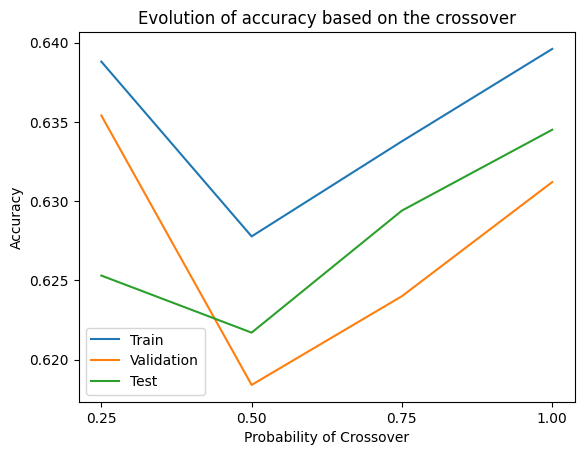

In [ ]:
rows = len(accuracies_gen)
plt.plot(crossovers, accuracies_gen['Train'])
plt.plot(crossovers, accuracies_gen['Validation'])
plt.plot(crossovers, accuracies_gen['Test'])

plt.title("Evolution of accuracy based on the crossover")
plt.xticks(crossovers)
plt.xlabel("Probability of Crossover")
plt.ylabel("Accuracy")
plt.legend(accuracies_gen.columns)
plt.show()  ## Crossover modification in genetic model

We can see that the probability of crossover does not clearly imply an improvement in the accuracy obtained by the model. This can be seen with 0.25 and 0.5, where the first one obtains better results in all the problem partitions. Moreover, the difference between 0.25 and 1.00 is not that big, with a lot of fluctuations among the partitions. Hence, using any of these two will be a valid option. However, after analyzing the execution time of each of the crossover probabilities, we have noticed that the higher the crossover, the higher the execution time (as long as more crossover implies more combination calculations to be performed). So, choosing **0.25** as the crossover proability for the genetic algortihm is the best option from the studied values being a tradeoff between performance and efficency.

## Mutation modification in evolutionary strategies

In this section, we will look for the best mutation percentage in the evolutionary algorithms for this simplest defined problem, i.e., no noise and small hardness.

In [ ]:
num_generations = 50
num_parents_mating = 5
sol_per_pop = 25
num_genes = featureSize * maxNumNeurons + maxNumNeurons + maxNumNeurons * targetSize + targetSize + bitsNumNeurons
keep_elitism = 2
init_range_low = 0
init_range_high = 1

In [ ]:
%%time
random.seed(randomState)
n_seeds = 5
possible_seeds = np.random.randint(1, 1000, n_seeds)
print("Seeds selected:", possible_seeds)

hardness = getClassSeparation(hardness=1)
mutations = [mutation for mutation in range(50, 101, 15)]

accuracies_evo = pd.DataFrame(columns=["Train", "Validation", "Test"])

for mutation in mutations:
    print(f"Running tests with mutation = {mutation} ...")

    train_scores_evo, val_scores_evo, test_scores_evo = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)

    for i, selected_seed in enumerate(possible_seeds):
        # Genetic model
        print(" " * 3 + f"Running evolutionary strategy with execution {i}")
        ga_instance = pygad.GA(num_generations=num_generations,
                               num_parents_mating=num_parents_mating,
                               fitness_func=fitness_func,
                               sol_per_pop=sol_per_pop,
                               gene_type=float,
                               keep_elitism=keep_elitism,
                               crossover_probability=0,  # Modified crossover
                               num_genes=num_genes,
                               init_range_low=init_range_low,
                               init_range_high=init_range_high,
                               mutation_percent_genes=mutation)
        ga_instance.run()
        solution, _, _ = ga_instance.best_solution()
        model = solToNet(solution)
        train_score_evo, val_score_evo, test_score_evo = getScores(model)

        train_scores_evo[i] = train_score_evo
        val_scores_evo[i] = val_score_evo
        test_scores_evo[i] = test_score_evo

    print(" " * 3 + "-" * 20)
    print(" " * 3 + "Average genetic values:")
    print(" " * 5 + f"Train accuracy      : {round(train_scores_evo.mean(), 5)}")
    print(" " * 5 + f"Validation accuracy : {round(val_scores_evo.mean(), 5)}")
    print(" " * 5 + f"Test accuracy       : {round(test_scores_evo.mean(), 5)}")

    accuracies_evo.loc[f"Mutation = {mutation}"] = [train_scores_evo.mean(), val_scores_evo.mean(),
                                                      test_scores_evo.mean()]
display(accuracies_evo)

Seeds selected: [103 436 861 271 107]
Running tests with mutation = 50 ...
   Running evolutionary strategy with execution 0
   Running evolutionary strategy with execution 1
   Running evolutionary strategy with execution 2
   Running evolutionary strategy with execution 3
   Running evolutionary strategy with execution 4
   --------------------
   Average genetic values:
     Train accuracy      : 0.64434
     Validation accuracy : 0.6348
     Test accuracy       : 0.634
Running tests with mutation = 65 ...
   Running evolutionary strategy with execution 0
   Running evolutionary strategy with execution 1
   Running evolutionary strategy with execution 2
   Running evolutionary strategy with execution 3
   Running evolutionary strategy with execution 4
   --------------------
   Average genetic values:
     Train accuracy      : 0.6378
     Validation accuracy : 0.6298
     Test accuracy       : 0.6331
Running tests with mutation = 80 ...
   Running evolutionary strategy with executi

Train  Validation    Test
Mutation = 50  0.644343      0.6348  0.6340
Mutation = 65  0.637800      0.6298  0.6331
Mutation = 80  0.634257      0.6248  0.6245
Mutation = 95  0.628943      0.6158  0.6123

Wall time: 1h 15min 35s


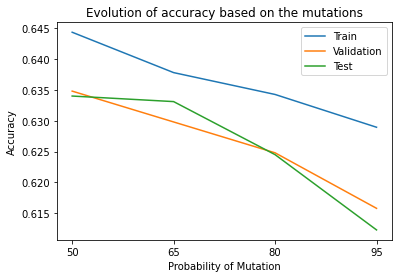

In [ ]:
plt.plot(mutations, accuracies_evo['Train'])
plt.plot(mutations, accuracies_evo['Validation'])
plt.plot(mutations, accuracies_evo['Test'])

plt.title("Evolution of accuracy based on the mutations")
plt.xticks(mutations)
plt.xlabel("Probability of Mutation")
plt.ylabel("Accuracy")
plt.legend(accuracies_evo.columns)
plt.show()

In this plot, we can see that increasing the mutation probability makes the model lose accuracy in all the partitions. This is reasonable as long as the higher the mutation probability means we have a higher chance of also losing great individuals, resulting in poor overall execution. Due to this, we can assume that a mutation with a probability even lower than 50% will be able to obtain the best results because we have already tried several smaller probabilities that led to similar or even worse results. Hence, we have decided that **50%** is the best mutation probability for the evolutionary strategy model.

## Testing noise effect

In this section, we modify the noise of the data in order to see how it affects the models. The noise is produced by the percentage of samples classified randomly (most probably wrongly classified). We will use the best parameters for crossover and mutation for the genetic algorithm and the best mutation parameter for the evolutionary algorithm. These parameters are the ones selected in the two previous sections. Moreover, we will set the hardness to be low (only 1 out of 10) and modify the noise from 0% to 100% in 25% steps. The final test with noise = 100% will be a test in which all samples are randomly classified, making it a difficult problem.

In [ ]:
num_generations = 50
num_parents_mating = 5
sol_per_pop = 25
num_genes = featureSize * maxNumNeurons + maxNumNeurons + maxNumNeurons * targetSize + targetSize + bitsNumNeurons
keep_elitism = 2
init_range_low = 0
init_range_high = 1
crossover_gen = 0.25
mutation_gen = 5
mutation_evo = 50

classSeparation = getClassSeparation(hardness=1)

In [ ]:
%%time
random.seed(randomState)
n_seeds = 5
possible_seeds = np.random.randint(1, 1000, n_seeds)
print("Seeds selected:", possible_seeds)

noises = [noise/100 for noise in range(0,101,25)]

accuracies_der = pd.DataFrame(columns=["Train", "Validation", "Test", "Time"])
accuracies_gen = pd.DataFrame(columns=["Train", "Validation", "Test", "Time", "Neurons"])
accuracies_evo = pd.DataFrame(columns=["Train", "Validation", "Test", "Time", "Neurons"])

for noise in noises:
    print(f"Running tests with noise = {noise} ...")

    train_scores, val_scores, test_scores, times = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)
    train_scores_gen, val_scores_gen, test_scores_gen, times_gen, neurons_gen = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)
    train_scores_evo, val_scores_evo, test_scores_evo, times_evo, neurons_evo = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)

    X, y = make_classification(n_samples=sampleSize, n_features=featureSize, n_informative=featureSize, n_redundant=0,
                           n_classes=targetSize, flip_y=noise, class_sep=classSeparation, hypercube=False, shift=None, shuffle=False, random_state=randomState)
    X = MinMaxScaler().fit_transform(X)
    X_aux, X_test, y_aux, y_test   = train_test_split(X, y, test_size=0.20, random_state=randomState, stratify=y) # Get 20% for test set
    # Get 10% for validation set (using 0.125 as the extraction is being made from the 80% resting dataset and 0.125*0.8=0.1)
    X_train, X_val, y_train, y_val = train_test_split(X_aux, y_aux, test_size=0.125, random_state=randomState, stratify=y_aux)

    for i, selected_seed in enumerate(possible_seeds):
        print(" "*3+f"Running derivative model with seed {selected_seed}")

        a = time.time()
        # Derivative model
        tf.random.set_seed(selected_seed)
        random.seed(selected_seed)
        model = Sequential()
        model.add(Dense(maxNumNeurons, input_dim=featureSize, activation='relu'))
        model.add(Dense(targetSize, activation='softmax'))
        model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())
        y_train_one_hot = get_dummies(y_train)
        model.fit(X_train,y_train_one_hot,epochs=50,verbose=0)
        train_score, val_score, test_score = getScores(model)

        train_scores[i] = train_score
        val_scores[i] = val_score
        test_scores[i] = test_score
        times[i] = time.time()-a


        # Genetic model
        print(" "*3+f"Running genetic model with seed {selected_seed}")
        a = time.time()
        ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_func,
                           sol_per_pop=sol_per_pop,
                           gene_type=float,
                           keep_elitism=keep_elitism,
                           crossover_probability=crossover_gen, # Modified crossover
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           mutation_percent_genes=mutation_gen)
        ga_instance.run()
        solution, _, _ = ga_instance.best_solution()
        model, numNeurons_gen = solToNet(solution)
        train_score_gen, val_score_gen, test_score_gen = getScores(model)
        train_scores_gen[i] = train_score_gen
        val_scores_gen[i] = val_score_gen
        test_scores_gen[i] = test_score_gen
        times_gen[i] = time.time()-a
        neurons_gen[i] = numNeurons_gen


        # Evolutional model
        print(" "*3+f"Running evolutional model with seed {selected_seed}")
        a = time.time()
        ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_func,
                           sol_per_pop=sol_per_pop,
                           gene_type=float,
                           keep_elitism=keep_elitism,
                           crossover_probability=0, # Modified crossover
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           mutation_percent_genes=mutation_evo)
        ga_instance.run()
        solution, _, _ = ga_instance.best_solution()
        model, numNeurons_evo = solToNet(solution)
        train_score_gen, val_score_gen, test_score_gen = getScores(model)
        train_scores_evo[i] = train_score_gen
        val_scores_evo[i] = val_score_gen
        test_scores_evo[i] = test_score_gen
        times_evo[i] = time.time()-a
        neurons_evo[i] = numNeurons_evo

    print(" "*3+"-"*20)
    print(" "*3 + "Average derivative values:")
    print(" "*5 + f"Train accuracy      : {round(train_scores.mean(), 5)}")
    print(" "*5 + f"Validation accuracy : {round(val_scores.mean(), 5)}")
    print(" "*5 + f"Test accuracy       : {round(test_scores.mean(), 5)}")
    print(" "*3+"-"*20)
    print(" "*3 + "Average genetic values:")
    print(" "*5 + f"Train accuracy      : {round(train_scores_gen.mean(), 5)}")
    print(" "*5 + f"Validation accuracy : {round(val_scores_gen.mean(), 5)}")
    print(" "*5 + f"Test accuracy       : {round(test_scores_gen.mean(), 5)}")
    print(" "*3+"-"*20)
    print(" "*3 + "Average evolutional values:")
    print(" "*5 + f"Train accuracy      : {round(train_scores_evo.mean(), 5)}")
    print(" "*5 + f"Validation accuracy : {round(val_scores_evo.mean(), 5)}")
    print(" "*5 + f"Test accuracy       : {round(test_scores_evo.mean(), 5)}")

    accuracies_der.loc[f"Noise = {noise}"] = [train_scores.mean(), val_scores.mean(), test_scores.mean(), times.mean()]
    accuracies_gen.loc[f"Noise = {noise}"] = [train_scores_gen.mean(), val_scores_gen.mean(), test_scores_gen.mean(), times_gen.mean(), neurons_gen.mean()]
    accuracies_evo.loc[f"Noise = {noise}"] = [train_scores_evo.mean(), val_scores_evo.mean(), test_scores_evo.mean(), times_evo.mean(), neurons_evo.mean()]

display(accuracies_der)
display(accuracies_gen)
display(accuracies_evo)

Seeds selected: [103 436 861 271 107]
Running tests with noise = 0.0 ...
   Running derivative model with seed 103
   Running genetic model with seed 103
   Running evolutional model with seed 103
   Running derivative model with seed 436
   Running genetic model with seed 436
   Running evolutional model with seed 436
   Running derivative model with seed 861
   Running genetic model with seed 861
   Running evolutional model with seed 861
   Running derivative model with seed 271
   Running genetic model with seed 271
   Running evolutional model with seed 271
   Running derivative model with seed 107
   Running genetic model with seed 107
   Running evolutional model with seed 107
   --------------------
   Average derivative values:
     Train accuracy      : 0.88977
     Validation accuracy : 0.8874
     Test accuracy       : 0.8805
   --------------------
   Average genetic values:
     Train accuracy      : 0.63826
     Validation accuracy : 0.6232
     Test accuracy       : 0.6

Train  Validation    Test      Time
Noise = 0.0   0.889771      0.8874  0.8805  9.530435
Noise = 0.25  0.780457      0.7716  0.7688  8.034157
Noise = 0.5   0.689600      0.6642  0.6730  8.083612
Noise = 0.75  0.581829      0.5856  0.5777  7.907998
Noise = 1.0   0.537400      0.5014  0.5000  7.497142

Train  Validation    Test        Time  Neurons
Noise = 0.0   0.638257      0.6232  0.6285  247.543311     74.6
Noise = 0.25  0.599286      0.5992  0.5893  231.194577     47.4
Noise = 0.5   0.569200      0.5616  0.5620  247.259474     32.4
Noise = 0.75  0.529314      0.5230  0.5272  236.160668    100.0
Noise = 1.0   0.515514      0.4992  0.5018  234.125338     29.2

Train  Validation    Test        Time  Neurons
Noise = 0.0   0.632486      0.6190  0.6278  251.516617     48.4
Noise = 0.25  0.603371      0.6038  0.5944  239.268936     83.0
Noise = 0.5   0.567400      0.5558  0.5608  248.603260     74.6
Noise = 0.75  0.534686      0.5332  0.5363  247.695187     75.6
Noise = 1.0   0.515686      0.4922  0.5043  240.323737     52.2

Wall time: 3h 25min 24s


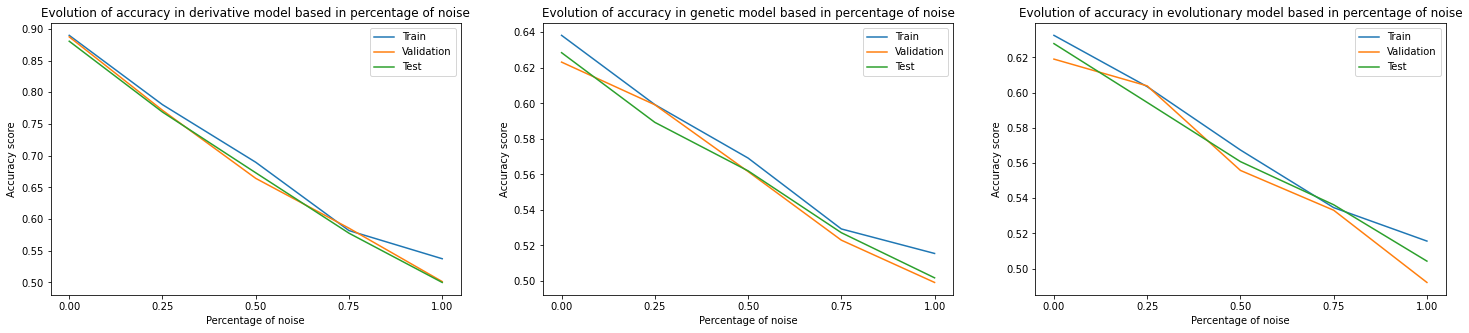

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(25,5))
axs[0].plot(noises, accuracies_der['Train'])
axs[0].plot(noises, accuracies_der['Validation'])
axs[0].plot(noises, accuracies_der['Test'])
axs[0].set_title("Evolution of accuracy in derivative model based in percentage of noise")
axs[0].set_xticks(noises)
axs[0].set_xlabel("Percentage of noise")
axs[0].set_ylabel("Accuracy score")
axs[0].legend(accuracies_der.columns)

axs[1].plot(noises, accuracies_gen['Train'])
axs[1].plot(noises, accuracies_gen['Validation'])
axs[1].plot(noises, accuracies_gen['Test'])
axs[1].set_title("Evolution of accuracy in genetic model based in percentage of noise")
axs[1].set_xticks(noises)
axs[1].set_xlabel("Percentage of noise")
axs[1].set_ylabel("Accuracy score")
axs[1].legend(accuracies_gen.columns)

axs[2].plot(noises, accuracies_evo['Train'])
axs[2].plot(noises, accuracies_evo['Validation'])
axs[2].plot(noises, accuracies_evo['Test'])
axs[2].set_title("Evolution of accuracy in evolutionary model based in percentage of noise")
axs[2].set_xticks(noises)
axs[2].set_xlabel("Percentage of noise")
axs[2].set_ylabel("Accuracy score")
axs[2].legend(accuracies_evo.columns)

plt.show()

On this plot, we can see the evolution of the accuracy with respect to the noise of the data. We can clearly see a trend in all the plots, with a line that decreases almost with the same slope for all the tested models. We can see that training, testing, and validation are quite similar in all the cases, and no significant differences can be found among them. It is really important to notice that, even if the general shape of the curves is the same, the initial accuracy score obtained with the derivative model (\~90%) is quite higher than the ones obtained with the evolutionary algorithms (\~63%). Note that it is really understandable that the accuracy will decrease as the noise increases, which is the expected result. Even so, the precise reduction in all three models really surprises us considering the fluctuations of the evolutionary algorithms, as we will see later in this document.

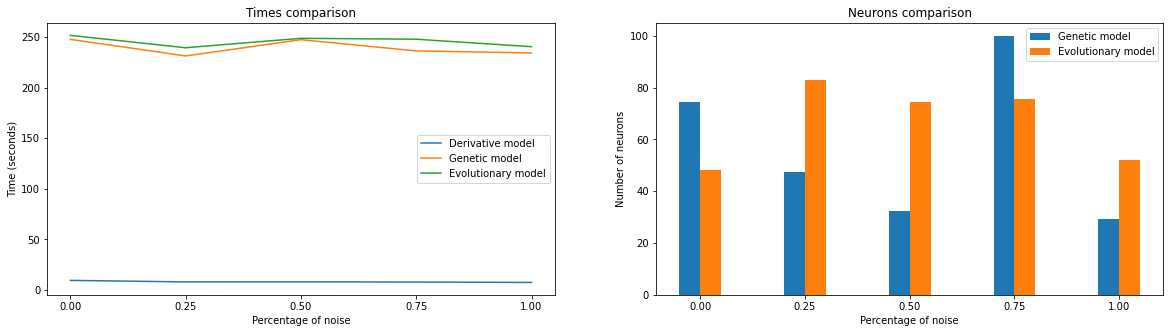

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].plot(noises, accuracies_der['Time'], label="Derivative model")
axs[0].plot(noises, accuracies_gen['Time'], label="Genetic model")
axs[0].plot(noises, accuracies_evo['Time'], label="Evolutionary model")
axs[0].set_title("Times comparison")
axs[0].set_xticks(noises)
axs[0].set_xlabel("Percentage of noise")
axs[0].set_ylabel("Time (seconds)")
axs[0].legend()

axs[1].bar(np.array(noises)-0.05/2, accuracies_gen['Neurons'], width = 0.05, label="Genetic model")
axs[1].bar(np.array(noises)+0.05/2, accuracies_evo['Neurons'], width = 0.05, label="Evolutionary model")
axs[1].set_title("Neurons comparison")
axs[1].set_xticks(noises)
axs[1].set_ylabel("Number of neurons")
axs[1].set_xlabel("Percentage of noise")
axs[1].legend()
plt.show()

Over here we find the execution time results as well as the number of neurons for each of the evolutionary algorithms. For the execution time, we can see that the genetic and evolutionary strategies are really time-consuming compared with the derivative mode. We can notice an increase of two orders of magnitude in all the cases. Moreover, the execution time seems to be independent of the amount of noise in the data. This is due to the fact that the execution times are mainly devoted to predicting the data and computing its accuracy, computations that work faster with smaller amounts of data.

On the other side, taking a look at the number of neurons, we can see that the values fluctuate quite a lot, with the evolutionary algorithms maintaining an average of around 80 and the genetic algorithms with quite more variations, going from around 35 to \~100 in some of the cases. These values represent the average of the best solutions found. As long as this kind of algorithm achieves really different results depending on the "luck" of the combinations and/or mutations, these values look plausible, and probably using more seeds to test would have led to more consistent results among the runs and a more meaningful average.

## Testing hardness effect

Now, once we have analyzed the effect of the noise in the models' training, we will try to understand each of the three models based on the hardness of the problem. As we mentioned above, we define hardness as the separation between the two classes in our dataset, where a smaller separation means more hardness. In this particular experiment, we will be using $[1, 3, 5, 7, 9]$ as hardness values, where 9 is the most difficult problem in this experiment.

As a final note, mention that we will use the same configurations as in the baselines; however, we will reduce the number of generations (50) in the genetic and evolutionary algorithms. We believe that the behavior of these two algorithms will remain consistent as the number of generations increases. Increasing the number of generations can improve accuracy, but the behavior in terms of hardness remains constant.

In [ ]:
num_generations = 50
num_parents_mating = 5
sol_per_pop = 25
num_genes = featureSize * maxNumNeurons + maxNumNeurons + maxNumNeurons * targetSize + targetSize + bitsNumNeurons
keep_elitism = 2
init_range_low = 0
init_range_high = 1
crossover_gen = 0.25
mutation_gen = 5
mutation_evo = 50

noise = 0

In [ ]:
%%time
random.seed(randomState)
n_seeds = 5
possible_seeds = np.random.randint(1, 1000, n_seeds)
print("Seeds selected:", possible_seeds)

hardnesses = [hardness for hardness in range(1,10,2)]

accuracies_der = pd.DataFrame(columns=["Train", "Validation", "Test", "Time"])
accuracies_gen = pd.DataFrame(columns=["Train", "Validation", "Test", "Time", "Neurons"])
accuracies_evo = pd.DataFrame(columns=["Train", "Validation", "Test", "Time", "Neurons"])

for hardness in hardnesses:
    print(f"Running tests with hardness = {hardness} ...")

    train_scores, val_scores, test_scores, times = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)
    train_scores_gen, val_scores_gen, test_scores_gen, times_gen, neurons_gen = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)
    train_scores_evo, val_scores_evo, test_scores_evo, times_evo, neurons_evo = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)

    X, y = make_classification(n_samples=sampleSize, n_features=featureSize, n_informative=featureSize, n_redundant=0,
                           n_classes=targetSize, flip_y=noise, class_sep=getClassSeparation(hardness), hypercube=False, shift=None, shuffle=False, random_state=randomState)
    X = MinMaxScaler().fit_transform(X)
    X_aux, X_test, y_aux, y_test   = train_test_split(X, y, test_size=0.20, random_state=randomState, stratify=y) # Get 20% for test set
    # Get 10% for validation set (using 0.125 as the extraction is being made from the 80% resting dataset and 0.125*0.8=0.1)
    X_train, X_val, y_train, y_val = train_test_split(X_aux, y_aux, test_size=0.125, random_state=randomState, stratify=y_aux)

    for i, selected_seed in enumerate(possible_seeds):
        print(" "*3+f"Running derivative model with seed {selected_seed}")

        a = time.time()
        # Derivative model
        tf.random.set_seed(selected_seed)
        random.seed(selected_seed)
        model = Sequential()
        model.add(Dense(maxNumNeurons, input_dim=featureSize, activation='relu'))
        model.add(Dense(targetSize, activation='softmax'))
        model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())
        y_train_one_hot = get_dummies(y_train)
        model.fit(X_train,y_train_one_hot,epochs=50,verbose=0)
        train_score, val_score, test_score = getScores(model)

        train_scores[i] = train_score
        val_scores[i] = val_score
        test_scores[i] = test_score
        times[i] = time.time()-a


        # Genetic model
        print(" "*3+f"Running genetic model with seed {selected_seed}")
        a = time.time()
        ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_func,
                           sol_per_pop=sol_per_pop,
                           gene_type=float,
                           keep_elitism=keep_elitism,
                           crossover_probability=crossover_gen, # Modified crossover
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           mutation_percent_genes=mutation_gen)
        ga_instance.run()
        solution, _, _ = ga_instance.best_solution()
        model, numNeurons_gen = solToNet(solution)
        train_score_gen, val_score_gen, test_score_gen = getScores(model)
        train_scores_gen[i] = train_score_gen
        val_scores_gen[i] = val_score_gen
        test_scores_gen[i] = test_score_gen
        times_gen[i] = time.time()-a
        neurons_gen[i] = numNeurons_gen


        # Evolutional model
        print(" "*3+f"Running evolutional model with seed {selected_seed}")
        a = time.time()
        ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_func,
                           sol_per_pop=sol_per_pop,
                           gene_type=float,
                           keep_elitism=keep_elitism,
                           crossover_probability=0, # Modified crossover
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           mutation_percent_genes=mutation_evo)
        ga_instance.run()
        solution, _, _ = ga_instance.best_solution()
        model, numNeurons_evo = solToNet(solution)
        train_score_gen, val_score_gen, test_score_gen = getScores(model)
        train_scores_evo[i] = train_score_gen
        val_scores_evo[i] = val_score_gen
        test_scores_evo[i] = test_score_gen
        times_evo[i] = time.time()-a
        neurons_evo[i] = numNeurons_evo

    print(" "*3+"-"*20)
    print(" "*3 + "Average derivative values:")
    print(" "*5 + f"Train accuracy      : {round(train_scores.mean(), 5)}")
    print(" "*5 + f"Validation accuracy : {round(val_scores.mean(), 5)}")
    print(" "*5 + f"Test accuracy       : {round(test_scores.mean(), 5)}")
    print(" "*3+"-"*20)
    print(" "*3 + "Average genetic values:")
    print(" "*5 + f"Train accuracy      : {round(train_scores_gen.mean(), 5)}")
    print(" "*5 + f"Validation accuracy : {round(val_scores_gen.mean(), 5)}")
    print(" "*5 + f"Test accuracy       : {round(test_scores_gen.mean(), 5)}")
    print(" "*3+"-"*20)
    print(" "*3 + "Average evolutional values:")
    print(" "*5 + f"Train accuracy      : {round(train_scores_evo.mean(), 5)}")
    print(" "*5 + f"Validation accuracy : {round(val_scores_evo.mean(), 5)}")
    print(" "*5 + f"Test accuracy       : {round(test_scores_evo.mean(), 5)}")

    accuracies_der.loc[f"Hardness = {hardness}"] = [train_scores.mean(), val_scores.mean(), test_scores.mean(), times.mean()]
    accuracies_gen.loc[f"Hardness = {hardness}"] = [train_scores_gen.mean(), val_scores_gen.mean(), test_scores_gen.mean(), times_gen.mean(), neurons_gen.mean()]
    accuracies_evo.loc[f"Hardness = {hardness}"] = [train_scores_evo.mean(), val_scores_evo.mean(), test_scores_evo.mean(), times_evo.mean(), neurons_evo.mean()]

display(accuracies_der)
display(accuracies_gen)
display(accuracies_evo)

Seeds selected: [103 436 861 271 107]
Running tests with hardness = 1 ...
   Running derivative model with seed 103
   Running genetic model with seed 103
   Running evolutional model with seed 103
   Running derivative model with seed 436
   Running genetic model with seed 436
   Running evolutional model with seed 436
   Running derivative model with seed 861
   Running genetic model with seed 861
   Running evolutional model with seed 861
   Running derivative model with seed 271
   Running genetic model with seed 271
   Running evolutional model with seed 271
   Running derivative model with seed 107
   Running genetic model with seed 107
   Running evolutional model with seed 107
   --------------------
   Average derivative values:
     Train accuracy      : 0.88977
     Validation accuracy : 0.8874
     Test accuracy       : 0.8805
   --------------------
   Average genetic values:
     Train accuracy      : 0.6292
     Validation accuracy : 0.6124
     Test accuracy       : 0.6

Train  Validation    Test      Time
Hardness = 1  0.889771      0.8874  0.8805  8.655260
Hardness = 3  0.888343      0.8900  0.8758  8.094010
Hardness = 5  0.885571      0.8906  0.8761  8.422330
Hardness = 7  0.886714      0.8918  0.8757  7.662436
Hardness = 9  0.885171      0.8862  0.8763  7.596561

Train  Validation    Test        Time  Neurons
Hardness = 1  0.629200      0.6124  0.6144  241.157652     65.0
Hardness = 3  0.630257      0.6238  0.6219  233.278642     83.0
Hardness = 5  0.611086      0.6070  0.6010  246.625500     72.2
Hardness = 7  0.579571      0.5788  0.5738  234.759565     72.2
Hardness = 9  0.578714      0.5712  0.5762  241.240192     77.6

Train  Validation    Test        Time  Neurons
Hardness = 1  0.630571      0.6184  0.6208  242.812734     91.2
Hardness = 3  0.616371      0.6044  0.6092  239.388736     59.6
Hardness = 5  0.610171      0.5946  0.6010  255.873325     68.8
Hardness = 7  0.583429      0.5786  0.5793  235.777958     51.4
Hardness = 9  0.581543      0.5840  0.5797  240.734066     91.8

Wall time: 3h 24min 20s


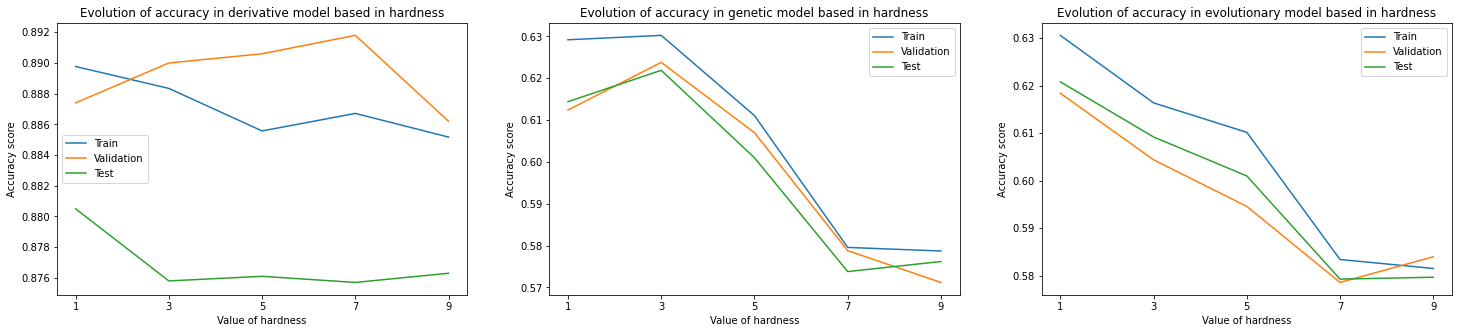

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(25,5))
axs[0].plot(hardnesses, accuracies_der['Train'])
axs[0].plot(hardnesses, accuracies_der['Validation'])
axs[0].plot(hardnesses, accuracies_der['Test'])
axs[0].set_title("Evolution of accuracy in derivative model based in hardness")
axs[0].set_xticks(hardnesses)
axs[0].set_xlabel("Value of hardness")
axs[0].set_ylabel("Accuracy score")
axs[0].legend(accuracies_der.columns)

axs[1].plot(hardnesses, accuracies_gen['Train'])
axs[1].plot(hardnesses, accuracies_gen['Validation'])
axs[1].plot(hardnesses, accuracies_gen['Test'])
axs[1].set_title("Evolution of accuracy in genetic model based in hardness")
axs[1].set_xticks(hardnesses)
axs[1].set_xlabel("Value of hardness")
axs[1].set_ylabel("Accuracy score")
axs[1].legend(accuracies_gen.columns)

axs[2].plot(hardnesses, accuracies_evo['Train'])
axs[2].plot(hardnesses, accuracies_evo['Validation'])
axs[2].plot(hardnesses, accuracies_evo['Test'])
axs[2].set_title("Evolution of accuracy in evolutionary model based in hardness")
axs[2].set_xticks(hardnesses)
axs[2].set_xlabel("Value of hardness")
axs[2].set_ylabel("Accuracy score")
axs[2].legend(accuracies_evo.columns)

plt.show()

To start with, we would like to remark that we have used five executions for each type of hardness. This means that we have computed average values for every algorithm. For instance, with hardness = 1, we have used 5 seeds for the derivative model, and 5 runs for the genetic and evolutionary algorithm. We consider that if we increased the value for runs to do the average, we will get smoother graphs; however, if we see the execution time of the experiment, we can see that the execution time is extremely high (3h 24min), and doubling the runs per hardness will mean doubling the execution time of the experiment. Once that is said, let's proceed to the analysis of the accuracy values.

If we look closely at the accuracy values of the three models depending on the hardness, we can see that there is a clear decreasing tendency, where higher hardness leads to less accuracy. We can appreciate that this decrease is more noticeable in the genetic and evolutionary models. With respect to the derivative model of 50 epochs, we can notice that the decrease in accuracy is minimal (only 0.005 % in the train). Moreover, we can appreciate that the same tendency is in the testing part, but the validation partition has some strange fluctuations, reaching the maximum average accuracy of the experiment with hardness = 7. We think this is ignorable because, with more seeds to test the model, we could get more stable results in the validation partition also.

With respect to the genetic and evolutionary strategies, we can notice that the decrease is more noticeable, going from around 63% to 58%. However, there is a main difference between them. The difference is that the genetic algorithm tends to obtain similar results with hardness 1 and 3, which means that with hardness 2, we would also have similar results. On the contrary, with the evolutionary algorithm, we can see that there is a decrease between hardness 1 and 3. From hardness 3, both tend to follow the same pattern. As a final note, mention that for hardnesses higher than 7, the decrease in accuracy is almost null because both algorithms treat hardnesses above 7 in the same way. If we analyzed the values from 7 to 10, we would see almost a constant line in accuracy.

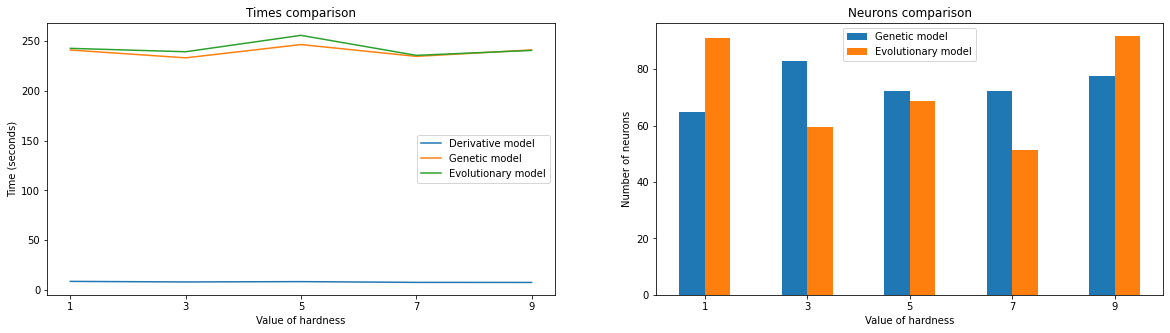

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].plot(hardnesses, accuracies_der['Time'], label="Derivative model")
axs[0].plot(hardnesses, accuracies_gen['Time'], label="Genetic model")
axs[0].plot(hardnesses, accuracies_evo['Time'], label="Evolutionary model")
axs[0].set_title("Times comparison")
axs[0].set_xticks(hardnesses)
axs[0].set_xlabel("Value of hardness")
axs[0].set_ylabel("Time (seconds)")
axs[0].legend()

axs[1].bar(np.array(hardnesses)-0.5/2, accuracies_gen['Neurons'], width = 0.5, label="Genetic model")
axs[1].bar(np.array(hardnesses)+0.5/2, accuracies_evo['Neurons'], width = 0.5, label="Evolutionary model")
axs[1].set_title("Neurons comparison")
axs[1].set_xticks(hardnesses)
axs[1].set_ylabel("Number of neurons")
axs[1].set_xlabel("Value of hardness")
axs[1].legend()
plt.show()

Once we discussed the accuracy, we could see that the time maintained the same pattern as in the noise effect experiment. We can notice that genetic and evolutionary algorithms take similar times per run, and the hardness values don't affect the execution time, which is logical because the number of generations is fixed. However, if we wanted the same results as the derivative model, we would see an increase in the execution time because a higher number of generations would be required. In contrast, the derivative models take around 200 times less time than the evolutionary algorithms.


Apart from that, we can see that the number of neurons fluctuates between 50 and 80. In some cases, we have more neurons in the genetic models, and in some cases, the evolutionary models have more neurons. However, the difference between models is small. As a final note, we would like to say that the derivative model uses the maximum number of neurons, which is 128.

## Testing training size effect

In this section, we are going to study a little bit the effect of modifying the training size. Recall that we have set the training size to 70% of the total data, and we will use $[10\%, 35\%, 60\%, 85\%]$ as percentages to try to get out of the original 70%. Thus, we will be using a real training size of $[7\%, 24.5\%, 42\%, 59.5\%]$ compared to the original data (10.000 samples). The main thing to anticipate is that the accuracy values will be slightly reduced due to the use of small amounts of data to train. Notice how we will keep the problem easy (0 noise and 1 hardness) and how we will use the best parameters for the crossover and mutation percentages for the genetic algorithm and the mutation percentage for the evolutionary one.

In [ ]:
num_generations = 50
num_parents_mating = 5
sol_per_pop = 25
num_genes = featureSize * maxNumNeurons + maxNumNeurons + maxNumNeurons * targetSize + targetSize + bitsNumNeurons
keep_elitism = 2
init_range_low = 0
init_range_high = 1
crossover_gen = 0.25
mutation_gen = 5
mutation_evo = 50

noise = 0
classSeparation = getClassSeparation(1)

In [ ]:
%%time
random.seed(randomState)
n_seeds = 5
possible_seeds = np.random.randint(1, 1000, n_seeds)
print("Seeds selected:", possible_seeds)

trainingSizes = [trainingSize/100 for trainingSize in range(10,100,25)]

accuracies_der = pd.DataFrame(columns=["Train", "Validation", "Test", "Time"])
accuracies_gen = pd.DataFrame(columns=["Train", "Validation", "Test", "Time", "Neurons"])
accuracies_evo = pd.DataFrame(columns=["Train", "Validation", "Test", "Time", "Neurons"])

for trainingSize in trainingSizes:
    print(f"Running tests with training size of {trainingSize} out of 0.7 ...")

    train_scores, val_scores, test_scores, times = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)
    train_scores_gen, val_scores_gen, test_scores_gen, times_gen, neurons_gen = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)
    train_scores_evo, val_scores_evo, test_scores_evo, times_evo, neurons_evo = np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds), np.zeros(n_seeds)

    X, y = make_classification(n_samples=sampleSize, n_features=featureSize, n_informative=featureSize, n_redundant=0,
                           n_classes=targetSize, flip_y=noise, class_sep=classSeparation, hypercube=False, shift=None, shuffle=False, random_state=randomState)
    X = MinMaxScaler().fit_transform(X)
    X_aux, X_test, y_aux, y_test   = train_test_split(X, y, test_size=0.20, random_state=randomState, stratify=y) # Get 20% for test set
    # Get 10% for validation set (using 0.125 as the extraction is being made from the 80% resting dataset and 0.125*0.8=0.1)
    X_aux, X_val, y_aux, y_val = train_test_split(X_aux, y_aux, test_size=0.125, random_state=randomState, stratify=y_aux)
    # Get trainingSize percentage out of 70% remaining train set
    _, X_train, _, y_train = train_test_split(X_aux, y_aux, test_size=trainingSize, random_state=randomState, stratify=y_aux)

    for i, selected_seed in enumerate(possible_seeds):
        print(" "*3+f"Running derivative model with seed {selected_seed}")

        a = time.time()
        # Derivative model
        tf.random.set_seed(selected_seed)
        random.seed(selected_seed)
        model = Sequential()
        model.add(Dense(maxNumNeurons, input_dim=featureSize, activation='relu'))
        model.add(Dense(targetSize, activation='softmax'))
        model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())
        y_train_one_hot = get_dummies(y_train)
        model.fit(X_train,y_train_one_hot,epochs=50,verbose=0)
        train_score, val_score, test_score = getScores(model)

        train_scores[i] = train_score
        val_scores[i] = val_score
        test_scores[i] = test_score
        times[i] = time.time()-a


        # Genetic model
        print(" "*3+f"Running genetic model with seed {selected_seed}")
        a = time.time()
        ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_func,
                           sol_per_pop=sol_per_pop,
                           gene_type=float,
                           keep_elitism=keep_elitism,
                           crossover_probability=crossover_gen, # Modified crossover
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           mutation_percent_genes=mutation_gen)
        ga_instance.run()
        solution, _, _ = ga_instance.best_solution()
        model, numNeurons_gen = solToNet(solution)
        train_score_gen, val_score_gen, test_score_gen = getScores(model)
        train_scores_gen[i] = train_score_gen
        val_scores_gen[i] = val_score_gen
        test_scores_gen[i] = test_score_gen
        times_gen[i] = time.time()-a
        neurons_gen[i] = numNeurons_gen


        # Evolutional model
        print(" "*3+f"Running evolutional model with seed {selected_seed}")
        a = time.time()
        ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_func,
                           sol_per_pop=sol_per_pop,
                           gene_type=float,
                           keep_elitism=keep_elitism,
                           crossover_probability=0, # Modified crossover
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           mutation_percent_genes=mutation_evo)
        ga_instance.run()
        solution, _, _ = ga_instance.best_solution()
        model, numNeurons_evo = solToNet(solution)
        train_score_gen, val_score_gen, test_score_gen = getScores(model)
        train_scores_evo[i] = train_score_gen
        val_scores_evo[i] = val_score_gen
        test_scores_evo[i] = test_score_gen
        times_evo[i] = time.time()-a
        neurons_evo[i] = numNeurons_evo

    print(" "*3+"-"*20)
    print(" "*3 + "Average derivative values:")
    print(" "*5 + f"Train accuracy      : {round(train_scores.mean(), 5)}")
    print(" "*5 + f"Validation accuracy : {round(val_scores.mean(), 5)}")
    print(" "*5 + f"Test accuracy       : {round(test_scores.mean(), 5)}")
    print(" "*3+"-"*20)
    print(" "*3 + "Average genetic values:")
    print(" "*5 + f"Train accuracy      : {round(train_scores_gen.mean(), 5)}")
    print(" "*5 + f"Validation accuracy : {round(val_scores_gen.mean(), 5)}")
    print(" "*5 + f"Test accuracy       : {round(test_scores_gen.mean(), 5)}")
    print(" "*3+"-"*20)
    print(" "*3 + "Average evolutional values:")
    print(" "*5 + f"Train accuracy      : {round(train_scores_evo.mean(), 5)}")
    print(" "*5 + f"Validation accuracy : {round(val_scores_evo.mean(), 5)}")
    print(" "*5 + f"Test accuracy       : {round(test_scores_evo.mean(), 5)}")

    accuracies_der.loc[f"TrainingSize = {round(trainingSize*0.7,2)}"] = [train_scores.mean(), val_scores.mean(), test_scores.mean(), times.mean()]
    accuracies_gen.loc[f"TrainingSize = {round(trainingSize*0.7,2)}"] = [train_scores_gen.mean(), val_scores_gen.mean(), test_scores_gen.mean(), times_gen.mean(), neurons_gen.mean()]
    accuracies_evo.loc[f"TrainingSize = {round(trainingSize*0.7,2)}"] = [train_scores_evo.mean(), val_scores_evo.mean(), test_scores_evo.mean(), times_evo.mean(), neurons_evo.mean()]

display(accuracies_der)
display(accuracies_gen)
display(accuracies_evo)

Seeds selected: [103 436 861 271 107]
Running tests with training size of 0.1 out of 0.7 ...
   Running derivative model with seed 103
   Running genetic model with seed 103
   Running evolutional model with seed 103
   Running derivative model with seed 436
   Running genetic model with seed 436
   Running evolutional model with seed 436
   Running derivative model with seed 861
   Running genetic model with seed 861
   Running evolutional model with seed 861
   Running derivative model with seed 271
   Running genetic model with seed 271
   Running evolutional model with seed 271
   Running derivative model with seed 107
   Running genetic model with seed 107
   Running evolutional model with seed 107
   --------------------
   Average derivative values:
     Train accuracy      : 0.77143
     Validation accuracy : 0.7238
     Test accuracy       : 0.7165
   --------------------
   Average genetic values:
     Train accuracy      : 0.646
     Validation accuracy : 0.609
     Test acc

Train  Validation    Test      Time
TrainingSize = 0.07  0.771429      0.7238  0.7165  1.360824
TrainingSize = 0.24  0.848327      0.8404  0.8362  3.165183
TrainingSize = 0.42  0.869476      0.8640  0.8610  4.969205
TrainingSize = 0.59  0.884235      0.8816  0.8764  6.844230

Train  Validation    Test        Time  Neurons
TrainingSize = 0.07  0.646000      0.6090  0.6241  111.098578     60.4
TrainingSize = 0.24  0.629306      0.6244  0.6285  139.950123     61.6
TrainingSize = 0.42  0.625476      0.6122  0.6214  174.398515     92.2
TrainingSize = 0.59  0.626286      0.6218  0.6187  214.052304     64.2

Train  Validation    Test        Time  Neurons
TrainingSize = 0.07  0.636286      0.6030  0.6146  112.157161     54.0
TrainingSize = 0.24  0.629306      0.6182  0.6189  145.709604     60.2
TrainingSize = 0.42  0.623905      0.6148  0.6220  179.440750     59.4
TrainingSize = 0.59  0.629277      0.6194  0.6217  222.887090     59.4

Wall time: 1h 49min 40s


In [ ]:
# Set training size to the real values
trainingSizes = np.array(trainingSizes)*0.7*100

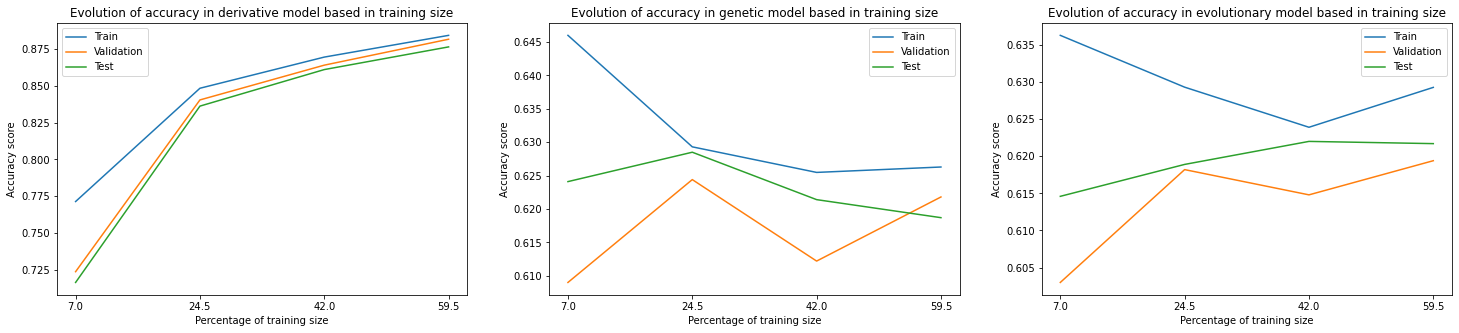

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(25,5))
axs[0].plot(trainingSizes, accuracies_der['Train'])
axs[0].plot(trainingSizes, accuracies_der['Validation'])
axs[0].plot(trainingSizes, accuracies_der['Test'])
axs[0].set_title("Evolution of accuracy in derivative model based in training size")
axs[0].set_xticks(trainingSizes)
axs[0].set_xlabel("Percentage of training size")
axs[0].set_ylabel("Accuracy score")
axs[0].legend(accuracies_der.columns)

axs[1].plot(trainingSizes, accuracies_gen['Train'])
axs[1].plot(trainingSizes, accuracies_gen['Validation'])
axs[1].plot(trainingSizes, accuracies_gen['Test'])
axs[1].set_title("Evolution of accuracy in genetic model based in training size")
axs[1].set_xticks(trainingSizes)
axs[1].set_xlabel("Percentage of training size")
axs[1].set_ylabel("Accuracy score")
axs[1].legend(accuracies_gen.columns)

axs[2].plot(trainingSizes, accuracies_evo['Train'])
axs[2].plot(trainingSizes, accuracies_evo['Validation'])
axs[2].plot(trainingSizes, accuracies_evo['Test'])
axs[2].set_title("Evolution of accuracy in evolutionary model based in training size")
axs[2].set_xticks(trainingSizes)
axs[2].set_xlabel("Percentage of training size")
axs[2].set_ylabel("Accuracy score")
axs[2].legend(accuracies_evo.columns)

plt.show()

On these three plots, we can see the evolution of the accuracy depending on the amount of training data used. The first one is the one representing the derivative model, while the other two represent the genetic and evolutionary algorithms, respectively. Take note of how, on the derivative model, increasing the training data size has the expected effect on the learning process, with greater performance (accuracy).This can be seen as well for the training as for the validation and testing partitions.

On the other side, we have the genetic model or algorithm where the fluctuations are quite high, even using the mean of five different runs. Even so, we can see that in a general overview, the accuracy values seem to be lower while the training size increases. This is not the normal behavior in the derivative models, but on both evolutionary algorithms, it seems a bit more this way. With respect to the testing set, we can see a similar reduction in accuracy. Lastly, the validation set is the one that fluctuates more and obtains really different values from one training percentage to another (this could be caused by the coincidence of random executions obtaining really sparse or "rare" values).

Then, for the evolutionary strategies, we can see a little bit the same thing as with the genetic algorithms, with the training size reducing its accuracy. However, in this case, this is quite good and is helping the model generalize because the validation and testing sets are directly improving their performance along the axis. This could be interpreted as the model losing some accuracy in the training set in order to generalize better new data and avoid overfitting the training set excessively. 

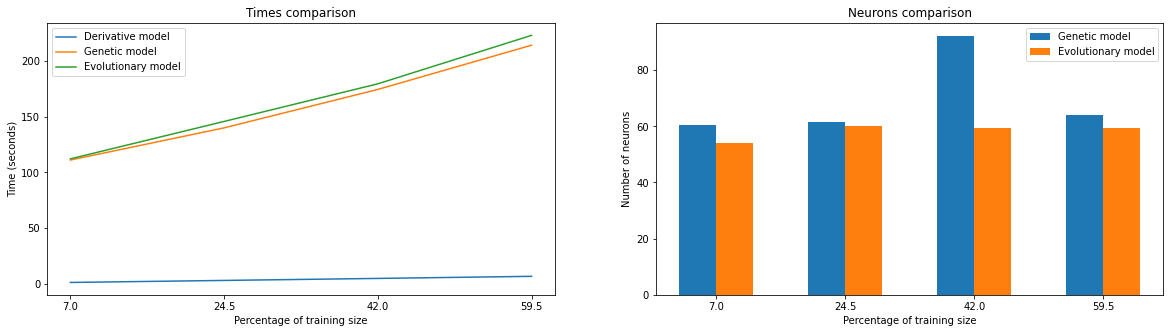

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].plot(trainingSizes, accuracies_der['Time'], label="Derivative model")
axs[0].plot(trainingSizes, accuracies_gen['Time'], label="Genetic model")
axs[0].plot(trainingSizes, accuracies_evo['Time'], label="Evolutionary model")
axs[0].set_title("Times comparison")
axs[0].set_xticks(trainingSizes)
axs[0].set_xlabel("Percentage of training size")
axs[0].set_ylabel("Time (seconds)")
axs[0].legend()

axs[1].bar(np.array(trainingSizes)-5/2, accuracies_gen['Neurons'], width = 5, label="Genetic model")
axs[1].bar(np.array(trainingSizes)+5/2, accuracies_evo['Neurons'], width = 5, label="Evolutionary model")
axs[1].set_title("Neurons comparison")
axs[1].set_xticks(trainingSizes)
axs[1].set_ylabel("Number of neurons")
axs[1].set_xlabel("Percentage of training size")
axs[1].legend()
plt.show()

Then, we have also computed the execution time of these algorithms and the number of neurons used. We can see how both the genetic and evolutionary models have a lot of trouble performing the learning process. The difference in execution time for the first percentage of training size is around two orders of magnitude higher with the evolutionary algorithms. Moreover, the almost parallel increase in the execution time of these two models seems to follow a clear pattern, with the genetic model being a little bit faster. This is a great representation of the differences in timing of those two big strategies to follow.

And, finally, for this section, we can see the plot on the right, which is a bar plot that shows the average number of hidden neurons for the best obtained solution. We didn't add the derivative model, as we fixed its number of layers to be 128 (the maximum number of layers). Here, we can see that they follow a really similar pattern, and around 60 neurons for all the cases seem to make the problem work properly. There is an exception with the genetic algorithm, which uses 42% of the population, where the number of neurons reaches around 90. This is kind of surprising, and we are not really sure why this is the case. However, the variability in this type of model is really high, and having these small differences could lead us to think that we should have used more seeds (which was not an option due to the prolonged execution time these experiments took).

## Conclusions


To start with the conclusions, we will do a general comparison of the models we studied previously. To begin, a comparison of the derivative and genetic algorithms shows that the derivative models outperform the genetic algorithms in this problem. We have seen that derivative models take insanely little time compared to genetic algorithms, and even they get better results. In order to achieve the same results as the derivative model, we need to have an extremely high number of generations. However, the increased time makes genetic algorithms a bad approach for this particular problem.


Following the evolution strategies, we have found a similar behavior to the derivative models. The execution time is extremely high and almost the same as the genetic algorithms. However, the accuracy values are roughly the same and can be improved by increasing the number of generations. This resemblance is unsettling due to the fact that genetic algorithms are a particular case of evolution strategies.


To finish with the comparison of the models, in the previous experiments we have seen that the derivative models have less execution time and better accuracy. On the contrary, genetic algorithms and evolution strategies have a lot more execution time and less accuracy. One positive thing about the evolution strategies in this problem is that they tend to use fewer neurons compared to the derivative models. The main problem with the evolution strategies is that at first they tend to improve a lot, but with every generation it becomes more difficult to find better individuals. As a final note, we would choose the derivative models to solve this particular problem. However, this may not be the case in other cases.


In general, we have seen that the derivative models are better than the genetic and evolutionary strategies. However, genetic algorithms give us the possibility to avoid an exhaustive search over all the parameters of the problem. The evolutionary algorithms enable us to discover excellent combinations that we would not have considered otherwise. In this particular and simple problem, we have seen that the genetic and evolutionary strategies don't have excellent results; however, they have better results in more complex problems such as:
  * Optimization problems: Genetic algorithms can be used to find the optimal solution to a problem, such as the shortest path between two points, or the maximum profit in a business.


  * Machine learning problems: Genetic algorithms can be used to improve the performance of machine learning models, such as neural networks, by finding the optimal set of weights and biases for the model.


  * Artificial intelligence problems: Genetic algorithms can be used to solve complex problems in artificial intelligence, such as finding the optimal strategy for playing a game or the best route for a self-driving car to take.


  * Search problems: Genetic algorithms can be used to search for solutions to problems that involve searching through a large space of possible solutions, such as finding the best configuration of a system or the best design for a product.


  * Combinatorial optimization problems: Genetic algorithms can be used to solve problems that involve finding the optimal combination of elements, such as scheduling problems or resource allocation problems.


We can appreciate that some of the problems are quite complex for basic neural networks and can be solved using genetic algorithms. We have poor results with our particular problem because we are using a tank to kill an ant. We need to understand that genetic algorithms are a powerful tool to solve extremely complex problems.


To conclude, we would like to add that doing this work, we have learned a lot about different types of neural networks and seen how so much information can be stored in just a few bits. We have seen that we can use the genetic algorithms to encode any type of problem and solve it. We would like to learn about them by trying to solve a more complex project. We will, however, leave this for future works.


